##### Copyright 2019 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Entrenamiento multitrabajador con Keras

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/multi_worker_with_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/distribute/multi_worker_with_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver código fuente en GitHub</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/distribute/multi_worker_with_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar bloc de notas</a>
</td>
</table>

## Visión general

Este tutorial demuestra cómo realizar un entrenamiento distribuido multitrabajador con un modelo Keras y la API `Model.fit` usando la API `tf.distribute.MultiWorkerMirroredStrategy`. Con la ayuda de esta estrategia, un modelo Keras que ha sido diseñado para ejecutarse en un único trabajador puede funcionar sin problemas en multitrabajador con cambios mínimos en el código.

Para aprender a usar la `MultiWorkerMirroredStrategy` con Keras y un bucle de entrenamiento personalizado, consulte [Bucle de entrenamiento personalizado con Keras y MultiWorkerMirroredStrategy](multi_worker_with_ctl.ipynb).

Este tutorial incluye un ejemplo mínimo de multitrabajador con dos trabajadores a modo de demostración.

### Elegir la estrategia adecuada

Antes de empezar, cerciórese de que `tf.distribute.MultiWorkerMirroredStrategy` es la opción adecuada para su(s) acelerador(es) y entrenamiento. Se trata de dos formas habituales de distribuir el entrenamiento con paralelismo de datos:

- *Entrenamiento síncrono*, en el que los pasos del entrenamiento se sincronizan entre los trabajadores y las réplicas, como `tf.distribute.MirroredStrategy`, `tf.distribute.TPUStrategy`, y `tf.distribute.MultiWorkerMirroredStrategy`. Todos los trabajadores se entrenan sobre diferentes porciones de datos de entrada de forma sincronizada, y agregando gradientes en cada paso.
- *Entrenamiento asíncrono*, en el que los pasos del entrenamiento no están estrictamente sincronizados, como `tf.distribute.experimental.ParameterServerStrategy`. Todos los trabajadores están entrenando de forma independiente sobre los datos de entrada y actualizando las variables de forma asíncrona.

Si lo que busca es un entrenamiento síncrono multitrabajador sin TPU, entonces necesita `tf.distribute.MultiWorkerMirroredStrategy`. Crea copias de todas las variables de las capas del modelo en cada dispositivo a través de todos los trabajadores. Usa `CollectiveOps`, una op de TensorFlow para la comunicación colectiva, para agregar gradientes y conserva las variables sincronizadas. Si está interesado, consulte la información sobre el parámetro `tf.distribute.experimental.CommunicationOptions` para ver las opciones de implementación de colectivos.

Consulte [Entrenamiento distribuido en TensorFlow](../../guide/distributed_training.ipynb) para ver un resumen de las API `tf.distribute.Strategy`.

## Preparación

Comience con algunas importaciones necesarias:

In [1]:
import json
import os
import sys

Antes de importar TensorFlow, realice algunos cambios en el entorno:

- En una aplicación del mundo real, cada trabajador estaría en una máquina diferente. Para efectos de este tutorial, todos los trabajadores se ejecutarán en la máquina **this**. Así pues, desactive todas las GPU para evitar errores causados por todos los trabajadores que intentan usar la misma GPU.

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

- Restablezca la variable de entorno `TF_CONFIG` (aprenderá más sobre esto más adelante):

In [3]:
os.environ.pop('TF_CONFIG', None)

- Asegúrese de que el directorio actual está en la ruta de Python; esto permite al bloc de notas importar posteriormente los archivos escritos por `%%writefile`:


In [4]:
if '.' not in sys.path:
  sys.path.insert(0, '.')

Instale `tf-nightly`, ya que la frecuencia de guardado de puntos de verificación en un paso concreto con el argumento `save_freq` en `tf.keras.callbacks.BackupAndRestore` se introduce a partir de TensorFlow 2.10:

In [5]:
!pip install tf-nightly

     -------------------------------------- 317.2/317.2 MB 6.7 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 28.6 MB/s eta 0:00:00
     ---------------------------------------- 5.5/5.5 MB 88.6 MB/s eta 0:00:00


ERROR: Could not install packages due to an OSError: [WinError 32] El proceso no tiene acceso al archivo porque está siendo utilizado por otro proceso: 'C:\\Users\\aleja\\Desktop\\Master\\05 - IA Generativa\\Desarrollo\\10-CNN\\.venv\\Scripts\\tensorboard.exe' -> 'C:\\Users\\aleja\\Desktop\\Master\\05 - IA Generativa\\Desarrollo\\10-CNN\\.venv\\Scripts\\tensorboard.exe.deleteme'
Check the permissions.



Finalmente, importe TensorFlow:

In [6]:
import tensorflow as tf

### Definición del conjunto de datos y del modelo

A continuación, cree un archivo `mnist_setup.py` con una configuración sencilla del modelo y el conjunto de datos. Este archivo Python será usado por los procesos de los trabajadores en este tutorial:

In [7]:
%%writefile mnist_setup.py

import os
import tensorflow as tf
import numpy as np

def mnist_dataset(batch_size):
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # The `x` arrays are in uint8 and have values in the [0, 255] range.
  # You need to convert them to float32 with values in the [0, 1] range.
  x_train = x_train / np.float32(255)
  y_train = y_train.astype(np.int64)
  train_dataset = tf.data.Dataset.from_tensor_slices(
      (x_train, y_train)).shuffle(60000).repeat().batch(batch_size)
  return train_dataset

def build_and_compile_cnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.InputLayer(input_shape=(28, 28)),
      tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
      tf.keras.layers.Conv2D(32, 3, activation='relu'),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
      metrics=['accuracy'])
  return model

Writing mnist_setup.py


### Entrenamiento de modelo en un solo trabajador

Pruebe a entrenar el modelo durante un pequeño número de épocas y observe los resultados de *un solo trabajador* para asegurarse de que todo funciona correctamente. Conforme avance el entrenamiento, la pérdida debería disminuir y la precisión debería aumentar.

In [8]:
import mnist_setup

batch_size = 64
single_worker_dataset = mnist_setup.mnist_dataset(batch_size)
single_worker_model = mnist_setup.build_and_compile_cnn_model()
single_worker_model.fit(single_worker_dataset, epochs=3, steps_per_epoch=70)

Epoch 1/3


c:\Users\aleja\Desktop\Master\05 - IA Generativa\Desarrollo\10-CNN\.venv\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1286 - loss: 2.2950
Epoch 2/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2361 - loss: 2.2495
Epoch 3/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3954 - loss: 2.1904


## Configuración multitrabajador

Entremos ahora en el mundo del entrenamiento multitrabajador.

### Un cluster con trabajos y tareas

En TensorFlow, el entrenamiento distribuido implica un `'cluster'` con varios trabajos, y cada uno de los trabajos puede tener una o más `'task'`.

Necesitará la variable de entorno de configuración `TF_CONFIG` para el entrenamiento en múltiples máquinas, cada una de las cuales posiblemente tenga un rol diferente. `TF_CONFIG` es una cadena JSON empleada para especificar la configuración del clúster para cada trabajador que forme parte del clúster.

Hay dos componentes de una variable `TF_CONFIG`: `'cluster'` y `'task'`.

- Un `'cluster'` es el mismo para todos los trabajadores y da información sobre el cluster de entrenamiento, que es un diccionario formado por diferentes tipos de trabajos, como `'worker'` o `'chief'`.

    - En el entrenamiento multitrabajador con `tf.distribute.MultiWorkerMirroredStrategy`, suele haber un `'worker'` que asume más responsabilidades, como guardar un punto de verificación y escribir un archivo sumario para TensorBoard, además de lo que hace un `'worker'` normal. A este `'worker'` se le identifica como el "worker" jefe (con un nombre de trabajo `'chief'`).
    - Es habitual que el trabajador con `'index'` `0` sea el `'chief'`.

- Una `'task'` da información sobre la tarea actual y es diferente para cada trabajador. Especifica el `'type'` y el `'index'` de ese trabajador.

Below is an example configuration:

In [9]:
tf_config = {
    'cluster': {
        'worker': ['localhost:12345', 'localhost:23456']
    },
    'task': {'type': 'worker', 'index': 0}
}

Tenga en cuenta que `tf_config` es sólo una variable local en Python. Para usarla para la configuración del entrenamiento, serialícela como JSON y colóquela en una variable de entorno `TF_CONFIG`.

In [10]:
json.dumps(tf_config)

'{"cluster": {"worker": ["localhost:12345", "localhost:23456"]}, "task": {"type": "worker", "index": 0}}'

En el ejemplo de configuración anterior, se establece el `'type'` de tarea a `'worker'` y el `'index'` de la tarea en `0`. Por lo tanto, esta máquina es la *primera* trabajadora. Será designada como el trabajador `'chief'`.

Nota: Otras máquinas necesitarán tener la variable de entorno `TF_CONFIG` establecida también, y deberá tener el mismo diccionario `'cluster'`, pero diferentes `'type'` de tareas o `'index'` de tareas, dependiendo de los roles de esas máquinas.

En la práctica, usted crearía varios trabajadores en direcciones IP/puertos externos y configuraría una variable `TF_CONFIG` en cada trabajador según corresponda. Como ejemplo, este tutorial muestra cómo puede configurar una variable `TF_CONFIG` con dos trabajadores en un `localhost`:

- El `TF_CONFIG` del primer trabajador (`'chief'`) como se muestra arriba.
- Para el segundo trabajador, fijará `tf_config['task']['index']=1`

### Variables de entorno y subprocesos en blocs de notas

Los subprocesos heredan las variables de entorno de su padre. Así que si configura una variable de entorno en este proceso de bloc de notas Jupyter:

In [11]:
os.environ['GREETINGS'] = 'Hello TensorFlow!'

... entonces puede acceder a la variable de entorno desde los subprocesos:

In [12]:
%%bash
echo ${GREETINGS}

En la siguiente sección, usará este método para pasar el `TF_CONFIG` a los subprocesos de los trabajadores. En un escenario real nunca ejecutaría sus trabajos de esta forma; este tutorial sólo muestra cómo hacerlo con un ejemplo multitrabajador mínimo.

## Entrenar el modelo

Para entrenar el modelo, cree en primer lugar una instancia del modelo `tf.distribute.MultiWorkerMirroredStrategy`:

In [13]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CommunicationImplementation.AUTO


Nota: `TF_CONFIG` se parsea y los servidores GRPC de TensorFlow se inician en el momento en que se llama a `MultiWorkerMirroredStrategy`, por lo que la variable de entorno `TF_CONFIG` debe configurarse antes de crear una instancia `tf.distribute.Strategy`. Dado que `TF_CONFIG` aún no está establecida, la estrategia anterior es efectivamente un entrenamiento para un solo trabajador.

Con la integración de la API `tf.distribute.Strategy` en `tf.keras`, el único cambio que hará para distribuir el entrenamiento a múltiples trabajadores es acotar la construcción del modelo y la llamada `model.compile` dentro de `strategy.scope()`. El ámbito de la estrategia de distribución dicta cómo y dónde se crean las variables, y en el caso de `MultiWorkerMirroredStrategy`, las variables creadas son `MirroredVariable`, y se replican en cada uno de los trabajadores.


In [14]:
with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
  multi_worker_model = mnist_setup.build_and_compile_cnn_model()

Nota: Actualmente existe una limitación en `MultiWorkerMirroredStrategy` en la que las operaciones TensorFlow deben crearse después de crear la instancia de la estrategia. Si se encuentra con el error `RuntimeError: Collective ops must be configured at program startup`, pruebe a crear la instancia de `MultiWorkerMirroredStrategy` al principio del programa y ponga el código que pueda crear ops después de instanciar la estrategia.

Para ejecutar realmente con `MultiWorkerMirroredStrategy` necesitará ejecutar procesos worker y pasarles un `TF_CONFIG`.

Al igual que el archivo `mnist_setup.py` escrito anteriormente, aquí está el `main.py` que cada trabajador ejecutará:

In [15]:
%%writefile main.py

import os
import json

import tensorflow as tf
import mnist_setup

per_worker_batch_size = 64
tf_config = json.loads(os.environ['TF_CONFIG'])
num_workers = len(tf_config['cluster']['worker'])

strategy = tf.distribute.MultiWorkerMirroredStrategy()

global_batch_size = per_worker_batch_size * num_workers
multi_worker_dataset = mnist_setup.mnist_dataset(global_batch_size)

with strategy.scope():
  # Model building/compiling need to be within `strategy.scope()`.
  multi_worker_model = mnist_setup.build_and_compile_cnn_model()


multi_worker_model.fit(multi_worker_dataset, epochs=3, steps_per_epoch=70)

Writing main.py


En el fragmento de código anterior, observe que `global_batch_size`, que se pasa a `Dataset.batch`, se configura en `per_worker_batch_size * num_workers`. Esto garantiza que cada trabajador procese lotes de `per_worker_batch_size` ejemplos independientemente del número de trabajadores.

El directorio actual contiene ahora ambos archivos Python:

In [16]:
%%bash
ls *.py

main.py
mnist_setup.py


Serialice el `TF_CONFIG` a JSON y añádalo a las variables de entorno:

In [17]:
os.environ['TF_CONFIG'] = json.dumps(tf_config)

Ahora, puede iniciar un proceso trabajador que ejecutará el `main.py` y usará el `TF_CONFIG`:

In [18]:
# first kill any previous runs
%killbgscripts

All background processes were killed.


In [19]:
%%bash --bg
python main.py &> job_0.log

Hay que tener en cuenta algunas cosas sobre el comando anterior:

1. Éste usa el `%%bash` que es una ["magia" de bloc de notas](https://ipython.readthedocs.io/en/stable/interactive/magics.html) para ejecutar algunos comandos bash.
2. Usa la bandera `--bg` para ejecutar el proceso `bash` en segundo plano, porque este trabajador no terminará. Espera a todos los trabajadores antes de iniciarse.

El proceso trabajador en segundo plano no imprimirá la salida en este bloc de notas, por lo que el `&>` redirige su salida a un archivo para que pueda inspeccionar lo sucedido en un archivo de registro más adelante.

Por lo tanto, espere unos segundos a que se inicie el proceso:

In [20]:
import time
time.sleep(10)

Ahora, inspeccione lo que se ha volcado en el archivo de registro del trabajador hasta el momento:

In [21]:
%%bash
cat job_0.log

-bash: line 1: python: command not found


La última línea del archivo de registro debería decir: `Started server with target: grpc://localhost:12345`. El primer trabajador ya está listo y está esperando a que todos los demás trabajadores estén listos para continuar.

Así que actualice el `tf_config` para que el proceso del segundo trabajador retome el trabajo:

In [22]:
tf_config['task']['index'] = 1
os.environ['TF_CONFIG'] = json.dumps(tf_config)

Inicie el segundo trabajador. Esto iniciará el entrenamiento, ya que todos los trabajadores están activos (por lo que no es necesario poner este proceso en segundo plano):

In [23]:
%%bash
python main.py

-bash: line 1: python: command not found


CalledProcessError: Command 'b'python main.py\n'' returned non-zero exit status 127.

Si se vuelven a revisar los registros escritos por el primer trabajador, se sabrá que participó en el entrenamiento de ese modelo:

In [24]:
%%bash
cat job_0.log

-bash: line 1: python: command not found


Nota: Esto puede correr más lento que la ejecución de prueba al principio de este tutorial porque ejecutar múltiples trabajadores en una sola máquina sólo añade sobrecarga. La meta aquí no es mejorar el tiempo de entrenamiento sino dar un ejemplo de entrenamiento multitrabajador.


In [25]:
# Delete the `TF_CONFIG`, and kill any background tasks so they don't affect the next section.
os.environ.pop('TF_CONFIG', None)
%killbgscripts

All background processes were killed.


## Entrenamiento multitrabajador a fondo


Por el momento, ha aprendido a realizar una configuración multitrabajador básica. El resto del tutorial repasa en detalle otros factores que pueden ser útiles o importantes para casos de uso reales.

### Fragmentación de conjuntos de datos

En el entrenamiento multitrabajador, *es necesario fragmentar el conjunto de datos* para garantizar la convergencia y el rendimiento.

El ejemplo de la sección anterior se basa en el autosharding predeterminado proporcionado por la API `tf.distribute.Strategy`. Puede controlar el fragmentado estableciendo la `tf.data.experimental.AutoShardPolicy` del `tf.data.experimental.DistributeOptions`.

Para saber más sobre *auto fragmentación*, consulte la [Guía de entrada distribuida](https://www.tensorflow.org/tutorials/distribute/input#sharding).

Aquí tiene un ejemplo rápido de cómo desactivar la auto fragmentación, para que cada réplica procese cada ejemplo (*no recomendado*):


In [26]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF

global_batch_size = 64
multi_worker_dataset = mnist_setup.mnist_dataset(batch_size=64)
dataset_no_auto_shard = multi_worker_dataset.with_options(options)

### Evaluación

Si pasa también el `validation_data` a `Model.fit`, alternará entre entrenamiento y evaluación para cada época. El trabajo de evaluación se distribuye entre el mismo grupo de trabajadores, y sus resultados se agregan y están disponibles para todos los trabajadores.

Parecido al entrenamiento, el conjunto de datos de validación se auto fragmenta a nivel de archivo. Debe configurar un tamaño de lote global en el conjunto de datos de validación y configurar los `validation_steps`.

Se recomienda utilizar un conjunto de datos repetido (llamando a `tf.data.Dataset.repeat`) para la evaluación.

Otra posibilidad es crear otra tarea que lea periódicamente los puntos de verificación y ejecute la evaluación. Esto es lo que hace un Estimator. Pero no se recomienda esta forma de realizar la evaluación, por lo que se omiten sus detalles.

### Rendimiento

Para mejorar el rendimiento del entrenamiento multitrabajador, puede probar lo siguiente:

- `tf.distribute.MultiWorkerMirroredStrategy` provee múltiples [implementaciones de comunicación de colectivos](https://www.tensorflow.org/api_docs/python/tf/distribute/experimental/CommunicationImplementation):

    - `RING` implementa colectivos en anillos usando gRPC como capa de comunicación entre hosts.
    - `NCCL` usa la [Librería de Comunicación Colectiva de NVIDIA](https://developer.nvidia.com/nccl) para implementar los colectivos.
    - `AUTO` deja la elección al runtime.

    La mejor elección para implementar colectivos depende del número y el tipo de GPU y de las interconexiones de red del cluster. Para anular la elección automática, especifique el parámetro `communication_options` del constructor de `MultiWorkerMirroredStrategy`. Por ejemplo:

    ```python
    communication_options=tf.distribute.experimental.CommunicationOptions(implementation=tf.distribute.experimental.CommunicationImplementation.NCCL)
    ```

- Haga cast de las variables a `tf.float` si es posible:

    - El modelo oficial de ResNet incluye [un ejemplo](https://github.com/tensorflow/models/blob/8367cf6dabe11adf7628541706b660821f397dce/official/resnet/resnet_model.py#L466) de cómo hacerlo.

### Tolerancia a fallos

En el entrenamiento síncrono, el cluster fallaría si uno de los trabajadores falla y no existe ningún mecanismo de recuperación de fallos.

Usar Keras con `tf.distribute.Strategy` ofrece la ventaja de la tolerancia a fallos cuando los trabajadores mueren o son inestables por algún otro motivo. Puede hacerlo conservando el estado de entrenamiento en el sistema de archivos distribuido de su elección, de forma que al reiniciar la instancia que falló o se adelantó previamente, se recupere el estado de entrenamiento.

Cuando un trabajador deja de estar disponible, otros trabajadores fallarán (posiblemente tras un tiempo de espera). En tales casos, es necesario reiniciar el trabajador no disponible, así como otros trabajadores que hayan fallado.

Nota: Anteriormente, la retrollamada `ModelCheckpoint` servía de mecanismo para restaurar el estado de entrenamiento tras un reinicio por fallo de un trabajo para el entrenamiento multitrabajador. El equipo de TensorFlow está añadiendo una nueva retrollamada [`BackupAndRestore`](#scrollTo=kmH8uCUhfn4w), que añade también el soporte al entrenamiento de un solo trabajador para una experiencia consistente, y ha eliminado la funcionalidad de tolerancia a fallos de la retrollamada `ModelCheckpoint` existente. A partir de ahora, las aplicaciones que dependan de este comportamiento deberán migrar a la nueva retrollamada `BackupAndRestore`.

#### La retrollamada `ModelCheckpoint`

La retrollamada `ModelCheckpoint` ya no ofrece la funcionalidad de tolerancia a fallos, así que use en su lugar la retrollamada [`BackupAndRestore`](#scrollTo=kmH8uCUhfn4w).

La retrollamada `ModelCheckpoint` aún puede usarse para guardar puntos de verificación. Sin embargo, si el entrenamiento se interrumpió o finalizó con éxito, para continuar el entrenamiento a partir del punto de verificación, el usuario es responsable de cargar el modelo manualmente.

De forma opcional, los usuarios pueden elegir guardar y restaurar el modelo/las ponderaciones fuera de la retrollamada `ModelCheckpoint`.

### Guardar y cargar modelos

Para guardar su modelo usando `model.save` o `tf.saved_model.save`, es necesario que la dirección de guardado sea diferente para cada trabajador.

- Para los trabajadores que no sean jefes, tendrá que guardar el modelo en un directorio temporal.
- Para el jefe, tendrá que guardar en el directorio de modelos proporcionado.

Los directorios temporales del trabajador deben ser únicos para evitar errores resultantes de que varios trabajadores intenten escribir en la misma ubicación.

El modelo guardado en todos los directorios es idéntico, y por lo general sólo hay que consultar el modelo guardado por el jefe para restaurarlo o usarlo.

Debe tener alguna lógica de limpieza que borre los directorios temporales creados por los trabajadores una vez que su entrenamiento se haya llenado.

La razón para guardar en el jefe y en los trabajadores al mismo tiempo es que podría estar agregando variables durante el punto de verificación, lo que requiere que tanto el jefe como los trabajadores participen en el protocolo de comunicación allreduce. Por otro lado, dejar que el jefe y los trabajadores guarden en el mismo directorio del modelo resultará en errores debido a la contención.

Usando la `MultiWorkerMirroredStrategy`, el programa se ejecuta en cada trabajador, y para saber si el trabajador actual es el jefe, aprovecha el objeto resolutor del cluster que tiene atributos `task_type` y `task_id`:

- `task_type` le indica cuál es el trabajo actual (por ejemplo, `'worker'`).
- `task_id` le indica el identificador del trabajador.
- El trabajador con `task_id == 0` es designado como trabajador jefe.

En el fragmento de código siguiente, la función `write_filepath` indica la ruta del archivo a escribir, que depende del `task_id` del trabajador:

- Para el trabajador jefe (con `task_id == 0`), escribe en la ruta del archivo original.
- Para otros trabajadores, crea un directorio temporal (`temp_dir`) con el `task_id` en la ruta del directorio para escribir en él:

In [27]:
model_path = '/tmp/keras-model'

def _is_chief(task_type, task_id):
  # Note: there are two possible `TF_CONFIG` configurations.
  #   1) In addition to `worker` tasks, a `chief` task type is use;
  #      in this case, this function should be modified to
  #      `return task_type == 'chief'`.
  #   2) Only `worker` task type is used; in this case, worker 0 is
  #      regarded as the chief. The implementation demonstrated here
  #      is for this case.
  # For the purpose of this Colab section, the `task_type` is `None` case
  # is added because it is effectively run with only a single worker.
  return (task_type == 'worker' and task_id == 0) or task_type is None

def _get_temp_dir(dirpath, task_id):
  base_dirpath = 'workertemp_' + str(task_id)
  temp_dir = os.path.join(dirpath, base_dirpath)
  tf.io.gfile.makedirs(temp_dir)
  return temp_dir

def write_filepath(filepath, task_type, task_id):
  dirpath = os.path.dirname(filepath)
  base = os.path.basename(filepath)
  if not _is_chief(task_type, task_id):
    dirpath = _get_temp_dir(dirpath, task_id)
  return os.path.join(dirpath, base)

task_type, task_id = (strategy.cluster_resolver.task_type,
                      strategy.cluster_resolver.task_id)
write_model_path = write_filepath(model_path, task_type, task_id)

Con eso, ya está listo para guardar:

Obsoleto: Para los objetos Keras, se recomienda usar el nuevo formato de alto nivel `.keras` y `tf.keras.Model.export`, como se demuestra en la guía [aquí](https://www.tensorflow.org/guide/keras/save_and_serialize). El formato SavedModel de bajo nivel sigue siendo compatible con el código existente.

In [28]:
multi_worker_model.save(write_model_path)

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/tmp\keras-model.

Como ya se ha descrito, más adelante el modelo sólo debe cargarse desde la ruta del archivo en el que guardó el trabajador jefe. Por lo tanto, elimine los temporales que hayan guardado los trabajadores no jefes:

In [29]:
if not _is_chief(task_type, task_id):
  tf.io.gfile.rmtree(os.path.dirname(write_model_path))

Ahora, cuando sea el momento de cargar, use la práctica API `tf.keras.models.load_model`, y continúe con el trabajo posterior.

Aquí, supongamos que sólo se usa un único trabajador para cargar y continuar el entrenamiento, en cuyo caso no se llama a `tf.keras.models.load_model` dentro de otro `strategy.scope()` (tenga en cuenta que `strategy = tf.distribute.MultiWorkerMirroredStrategy()`, como se definió anteriormente):

In [30]:
loaded_model = tf.keras.models.load_model(model_path)

# Now that the model is restored, and can continue with the training.
loaded_model.fit(single_worker_dataset, epochs=2, steps_per_epoch=20)

ValueError: File format not supported: filepath=/tmp/keras-model. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(/tmp/keras-model, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

### Guardado y restauración del punto de verificación

Por otro lado, el punto de verificación le permite guardar las ponderaciones de su modelo y restaurarlas sin tener que guardar todo el modelo.

Aquí, creará un `tf.train.Checkpoint` que realice el seguimiento del modelo, que será administrado por el `tf.train.CheckpointManager`, de forma que sólo se conserve el último punto de verificación:

In [31]:
checkpoint_dir = '/tmp/ckpt'

checkpoint = tf.train.Checkpoint(model=multi_worker_model)
write_checkpoint_dir = write_filepath(checkpoint_dir, task_type, task_id)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, directory=write_checkpoint_dir, max_to_keep=1)

Una vez configurado el `CheckpointManager`, ya está listo para guardar y eliminar los puntos de verificación que hayan guardado los trabajadores no jefes:

In [32]:
checkpoint_manager.save()
if not _is_chief(task_type, task_id):
  tf.io.gfile.rmtree(write_checkpoint_dir)

PermissionDeniedError: {{function_node __wrapped__MergeV2Checkpoints_device_/job:localhost/replica:0/task:0/device:CPU:0}} Failed to create a directory: /; Permission denied [Op:MergeV2Checkpoints]

Ahora, cuando necesite restaurar el modelo, puede encontrar el último punto de verificación guardado usando la práctica función `tf.train.latest_checkpoint`. Tras restaurar el punto de verificación, puede continuar con el entrenamiento.

In [33]:
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest_checkpoint)
multi_worker_model.fit(multi_worker_dataset, epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1017 - loss: 2.3019
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1517 - loss: 2.2805


#### La retrollamada `BackupAndRestore`

La retrollamada `tf.keras.callbacks.BackupAndRestore` ofrece la funcionalidad de tolerancia a fallos haciendo una copia de seguridad del modelo y del estado actual del entrenamiento en un archivo temporal de puntos de verificación bajo el argumento `backup_dir` a `BackupAndRestore`.

Nota: En Tensorflow 2.9, se realiza una copia de seguridad del modelo actual y del estado de entrenamiento en los límites de las épocas. En la versión `tf-nightly` y a partir de TensorFlow 2.10, la retrollamada `BackupAndRestore` puede realizar una copia de seguridad del modelo y del estado de entrenamiento en los límites de época o de paso. `BackupAndRestore` acepta un argumento opcional `save_freq`. `save_freq` acepta ya sea `'epoch'` o un valor `int`. Si `save_freq` se configura como `'epoch'` se realiza una copia de seguridad del modelo después de cada época. Si `save_freq` se configura como valor entero superior a `0`, se realiza una copia de seguridad del modelo después de cada `save_freq` número de lotes.

Una vez que los trabajos se interrumpen y se reinician, la retrollamada `BackupAndRestore` restaura el último punto de verificación, y puede continuar el entrenamiento desde el principio de la época y el paso en los que se guardó por última vez el estado de entrenamiento.

Para usarlo, facilite una instancia de `tf.keras.callbacks.BackupAndRestore` en la llamada `Model.fit`.

Con `MultiWorkerMirroredStrategy`, si un trabajador es interrumpido, todo el cluster hará una pausa hasta que el trabajador interrumpido vuelva a arrancar. Los demás trabajadores también se reiniciarán y el trabajador interrumpido volverá a unirse al clúster. Entonces, cada trabajador leerá el archivo de punto de verificación que se guardó previamente y retomará su estado anterior, permitiendo así que el clúster vuelva a entrar en sincronía. A continuación, continuará el entrenamiento. El estado del iterador del conjunto de datos distribuido se reiniciará y no se restaurará.

La retrollamada `BackupAndRestore` usa el `CheckpointManager` para guardar y restaurar el estado de entrenamiento, lo que genera un archivo llamado checkpoint que hace un seguimiento de los puntos de verificación existentes junto con el más reciente. Por este motivo, `backup_dir` no debe usarse para almacenar otros puntos de verificación a fin de evitar la colisión de nombres.

Actualmente, la retrollamada `BackupAndRestore` admite el entrenamiento de un solo trabajador sin estrategia (`MirroredStrategy`) y el entrenamiento multitrabajador con `MultiWorkerMirroredStrategy`.

He aquí dos ejemplos tanto para el entrenamiento de multitrabajadores como para el de un solo trabajador:

In [34]:
# Multi-worker training with `MultiWorkerMirroredStrategy`
# and the `BackupAndRestore` callback. The training state 
# is backed up at epoch boundaries by default.

callbacks = [tf.keras.callbacks.BackupAndRestore(backup_dir='/tmp/backup')]
with strategy.scope():
  multi_worker_model = mnist_setup.build_and_compile_cnn_model()
multi_worker_model.fit(multi_worker_dataset,
                       epochs=3,
                       steps_per_epoch=70,
                       callbacks=callbacks)

Epoch 1/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1551 - loss: 2.2902
Epoch 2/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2884 - loss: 2.2404
Epoch 3/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4151 - loss: 2.1875


Si el argumento `save_freq` de la retrollamada `BackupAndRestore` se configura como `'epoch'`, se realiza una copia de seguridad del modelo después de cada época.

In [35]:
# The training state is backed up at epoch boundaries because `save_freq` is
# set to `epoch`.

callbacks = [tf.keras.callbacks.BackupAndRestore(backup_dir='/tmp/backup')]
with strategy.scope():
  multi_worker_model = mnist_setup.build_and_compile_cnn_model()
multi_worker_model.fit(multi_worker_dataset,
                       epochs=3,
                       steps_per_epoch=70,
                       callbacks=callbacks)


Epoch 1/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1394 - loss: 2.2954
Epoch 2/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2959 - loss: 2.2247
Epoch 3/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4187 - loss: 2.1500


Nota: El siguiente bloque de código usa funciones que sólo disponibles en `tf-nightly` hasta que se publique Tensorflow 2.10.

Si el argumento `save_freq` de la retrollamada `BackupAndRestore` se configura en un valor entero superior a `0`, se hace una copia de seguridad del modelo después de cada `save_freq` número de lotes.

In [36]:
# The training state is backed up at every 30 steps because `save_freq` is set
# to an integer value of `30`.

callbacks = [tf.keras.callbacks.BackupAndRestore(backup_dir='/tmp/backup', save_freq=30)]
with strategy.scope():
  multi_worker_model = mnist_setup.build_and_compile_cnn_model()
multi_worker_model.fit(multi_worker_dataset,
                       epochs=3,
                       steps_per_epoch=70,
                       callbacks=callbacks)

Epoch 1/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1055 - loss: 2.3037
Epoch 2/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2301 - loss: 2.2585
Epoch 3/3
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3578 - loss: 2.2106


Si examina el directorio de `backup_dir` que especificó en `BackupAndRestore`, puede que note algunos archivos de puntos de verificación generados temporalmente. Esos archivos son necesarios para recuperar las instancias perdidas anteriormente, y serán eliminados por la librería al final de `Model.fit` al salir con éxito de su entrenamiento.

Nota: Actualmente la retrollamada `BackupAndRestore` sólo soporta eager mode. En modo grafo, considere usar `Model.save`/`tf.saved_model.save` y `tf.keras.models.load_model` para guardar y recuperar modelos, respectivamente, como se describe en la sección *Guardar y cargar modelos* anterior, y proporcionando `initial_epoch` en `Model.fit` durante el entrenamiento.

## Recursos adicionales

1. La guía [Entrenamiento distribuido en TensorFlow](../../guide/distributed_training.ipynb) proporciona una visión general de las estrategias de distribución disponibles.
2. El tutorial [Bucle de entrenamiento personalizado con Keras y MultiWorkerMirroredStrategy](multi_worker_with_ctl.ipynb) muestra cómo usar la `MultiWorkerMirroredStrategy` con Keras y un bucle de entrenamiento personalizado.
3. Consulte los [modelos oficiales](https://github.com/tensorflow/models/tree/master/official), muchos de los cuales pueden configurarse para ejecutar múltiples estrategias de distribución.
4. La guía [Un mejor rendimiento con tf.function](../../guide/function.ipynb) ofrece información sobre otras estrategias y herramientas, como el [Perfilador TensorFlow](../../guide/profiler.md) que puede usar para optimizar el rendimiento de sus modelos TensorFlow.

##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a></td>
</table>

# Clasificación de videos con una red neuronal convolucional 3D

Este tutorial demuestra el entrenamiento de una red neuronal convolucional 3D (CNN) para la clasificación de vídeos utilizando el conjunto de datos de reconocimiento de acciones [UCF101](https://www.crcv.ucf.edu/data/UCF101.php). Una CNN 3D utiliza un filtro tridimensional para realizar las convoluciones. El núcleo puede deslizarse en tres direcciones, mientras que en una CNN 2D puede deslizarse en dos dimensiones. El modelo se basa en el trabajo publicado en [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) por D. Tran et al. (2017).  En este tutorial, usted:

- Construirá una canalización de entrada
- Construirá un modelo de red neuronal convolucional 3D con conexiones residuales usando la API funcional de Keras
- Entrenará el modelo
- Evaluará y probará el modelo

Este video tutorial de clasificación es la segunda parte de una serie de video tutoriales de TensorFlow. Aquí están los otros tres tutoriales:

- [Cargar datos de vídeo](https://www.tensorflow.org/tutorials/load_data/video): Este tutorial explica gran parte del código usado en este documento.
- [MoViNet para el reconocimiento de acciones en streaming](https://www.tensorflow.org/hub/tutorials/movinet): Familiarícese con los modelos MoViNet disponibles en TF Hub.
- [Aprendizaje por transferencia para la clasificación de vídeo con MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): Este tutorial explica cómo usar un modelo de clasificación de vídeo preentrenado y entrenado en un conjunto de datos diferente con el conjunto de datos UCF-101.

## Preparación

Comience instalando e importando algunas librerías necesarias, incluyendo: [remotezip](https://github.com/gtsystem/python-remotezip) para inspeccionar el contenido de un archivo ZIP, [tqdm](https://github.com/tqdm/tqdm) para usar una barra de progreso, [OpenCV](https://opencv.org/) para procesar archivos de vídeo, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) para realizar operaciones tensoriales más complejas, y [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) para incorporar datos en un bloc de notas de Jupyter.

**Nota**: Use TensorFlow 2.10 para ejecutar este tutorial. Es posible que las versiones superiores a TensorFlow 2.10 no se ejecuten correctamente.

In [37]:
!pip install remotezip tqdm opencv-python einops 
# Install TensorFlow 2.10
!pip install tensorflow==2.10.0

     --------------------------------------- 39.5/39.5 MB 65.1 MB/s eta 0:00:00


     ------------------------------------- 455.9/455.9 MB 10.4 MB/s eta 0:00:00
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl (895 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_auth-2.38.0-py2.py3-none-any.whl (210 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached cachetools-5.5.2-py3-none-any.whl (10 kB)
  Using cached pyasn1_modules-0.4.2-py3-none-any.whl (181 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl (24 kB)
  Using cached pyasn1-0.6.1-py

ERROR: Could not install packages due to an OSError: [WinError 5] Acceso denegado: 'C:\\Users\\aleja\\Desktop\\Master\\05 - IA Generativa\\Desarrollo\\10-CNN\\.venv\\Lib\\site-packages\\google\\~upb\\_message.pyd'
Check the permissions.



In [39]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

## Carga y procesamiento de datos de video

La celda oculta inferior define funciones ayudantes para descargar una porción de datos del conjunto de datos UCF-101 y cargarla en un `tf.data.Dataset`. Puede aprender más sobre los pasos específicos del preprocesamiento en el tutorial [Carga de datos de video](../load_data/video.ipynb), que le guiará a través de este código con más detalle.

La clase `FrameGenerator` al final del bloque oculto es la utilidad más importante en este caso. Crea un objeto iterable que puede alimentar los datos en la canalización de datos de TensorFlow. Específicamente, esta clase contiene un generador Python que carga los cuadros de video junto con su etiqueta codificada. La función del generador (`__call__`) produce el arreglo del marco emitido por `frames_from_video_file` y un vector codificado en un solo paso (one-hot) de la etiqueta asociada con el conjunto de cuadros.

In [40]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [41]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


100%|██████████| 300/300 [02:59<00:00,  1.67it/s]


val :


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


test :


100%|██████████| 100/100 [00:57<00:00,  1.73it/s]


Cree los conjuntos de entrenamiento, validación y prueba (`train_ds`, `val_ds` y `test_ds`).

In [42]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## Crear el modelo

El siguiente modelo de red neuronal convolucional 3D se basa en el artículo [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) de D. Tran et al. (2017). El artículo compara varias versiones de ResNets 3D. En lugar de operar sobre una sola imagen con dimensiones `(height, width)`, como las ResNets estándares, estas operan sobre el volumen de vídeo `(time, height, width)`. El enfoque más obvio a este problema sería reemplazar cada (`layers.Conv2D`) de convolución 2D por una convolución 3D (`layers.Conv3D`).

Este tutorial usa una convolución (2 + 1)D con [conexiones residuales](https://arxiv.org/abs/1512.03385). La convolución (2 + 1)D permite descomponer las dimensiones espacial y temporal, creando así dos pasos separados. Una ventaja de este enfoque es que la factorización de las convoluciones en dimensiones espaciales y temporales ahorra parámetros.

Para cada ubicación de salida, una convolución 3D combina todos los vectores de un parche 3D del volumen para crear un vector en el volumen de salida.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

Esta operación toma entradas `time * height * width * channels` y produce salidas `channels` (suponiendo que el número de canales de entrada y de salida sea el mismo. Así, una capa de convolución 3D con un tamaño de kernel de `(3 x 3 x 3)` necesitaría una matriz de ponderación con entradas de `27 * canales ** 2`. El documento de referencia encontró que un enfoque más eficaz y eficiente era factorizar la convolución. En lugar de una única convolución 3D para procesar las dimensiones temporal y espacial, propusieron una convolución "(2+1)D" que procesa las dimensiones espacial y temporal por separado. La figura siguiente muestra las convoluciones espacial y temporal factorizadas de una convolución (2 + 1)D.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

La principal ventaja de este enfoque es que reduce el número de parámetros. En la convolución (2 + 1)D, la convolución espacial toma datos de la forma `(1, width, height)`, mientras que la convolución temporal toma datos de la forma `(time, 1, 1)`. Por ejemplo, una convolución (2 + 1)D con tamaño de kernel `(3 x 3 x 3)` necesitaría matrices de ponderación de tamaño `(9 * channels**2) + (3 * channels**2)`, menos de la mitad que la convolución 3D completa. Este tutorial implementa la ResNet18 (2 + 1)D, en la que cada convolución de la resnet se sustituye por una convolución (2+1)D.

In [43]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [44]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

Un modelo ResNet se elabora a partir de una secuencia de bloques residuales. Un bloque residual tiene dos ramas. La rama principal realiza el cálculo, pero dificulta el paso de los gradientes. La derivación residual pasa por alto el cálculo principal y, en la mayoría de los casos, se limita a añadir la entrada a la salida de la rama principal. Los gradientes fluyen fácilmente a través de esta rama. Por lo tanto, habrá una ruta fácil desde la función de pérdida hasta cualquiera de las ramas principales del bloque residual. Esto evita el problema del gradiente evanescente.

Cree la rama principal del bloque residual con la siguiente clase. A diferencia de la estructura estándar de ResNet, ésta utiliza la capa personalizada `Conv2Plus1D` en lugar de `layers.Conv2D`.

In [45]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

Para añadir la rama residual a la rama principal es necesario que tenga el mismo tamaño. La capa `Project` inferior se ocupa de los casos en los que se modifica el número de canales en la derivación. En concreto, se añade una secuencia de capa densamente conectada seguida de normalización. 

In [46]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` para crear una conexión de salto entre las capas del modelo.

In [47]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Es necesario cambiar el tamaño del vídeo para realizar un downsampling de los datos. En concreto, el downsampling de los fotogramas de vídeo permite que el modelo examine partes concretas de los fotogramas para detectar patrones que puedan ser específicos de una determinada acción. Mediante el downsampling, se puede descartar la información no esencial. Además, redimensionar el vídeo permitirá reducir la dimensionalidad y, por tanto, acelerar el procesamiento a través del modelo.

In [48]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Usa la API funcional [Keras](https://www.tensorflow.org/guide/keras/functional) para construir la red residual.

In [49]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [50]:
frames, label = next(iter(train_ds))
model.build(frames)

In [51]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


## Entrenar el modelo

Para este tutorial, seleccione el optimizador `tf.keras.optimizers.Adam` y la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy`. Use el argumento `metrics` para ver la precisión del rendimiento del modelo en cada paso.

In [52]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Entrene el modelo durante 50 épocas con el método `Model.fit` de Keras.

Nota: Este modelo de ejemplo se entrena con menos puntos de datos (300 ejemplos de entrenamiento y 100 de validación) para mantener un tiempo de entrenamiento razonable para este tutorial. Además, este modelo de ejemplo puede tardar más de una hora en entrenarse.

In [53]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50
     38/Unknown 72s 2s/step - accuracy: 0.0914 - loss: 2.7478

c:\Users\aleja\Desktop\Master\05 - IA Generativa\Desarrollo\10-CNN\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.0916 - loss: 2.7441 - val_accuracy: 0.1900 - val_loss: 2.3667
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.1671 - loss: 2.2299 - val_accuracy: 0.1000 - val_loss: 2.4898
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.1868 - loss: 2.1346 - val_accuracy: 0.1500 - val_loss: 2.5815
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2740 - loss: 2.0661 - val_accuracy: 0.1400 - val_loss: 2.3369
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.3321 - loss: 1.8346 - val_accuracy: 0.1800 - val_loss: 2.5220
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.3085 - loss: 1.8701 - val_accuracy: 0.1600 - val_loss: 2.1976
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.3448 - loss: 1.7058 - val_accuracy: 0.1100 - val_loss: 2.4891
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4026 - loss: 1.6853 - val_accuracy: 0.2700 - val_loss: 2.0874
Ep

### Visualizar los resultados

Cree gráficos de la pérdida y la precisión en los conjuntos de entrenamiento y validación:

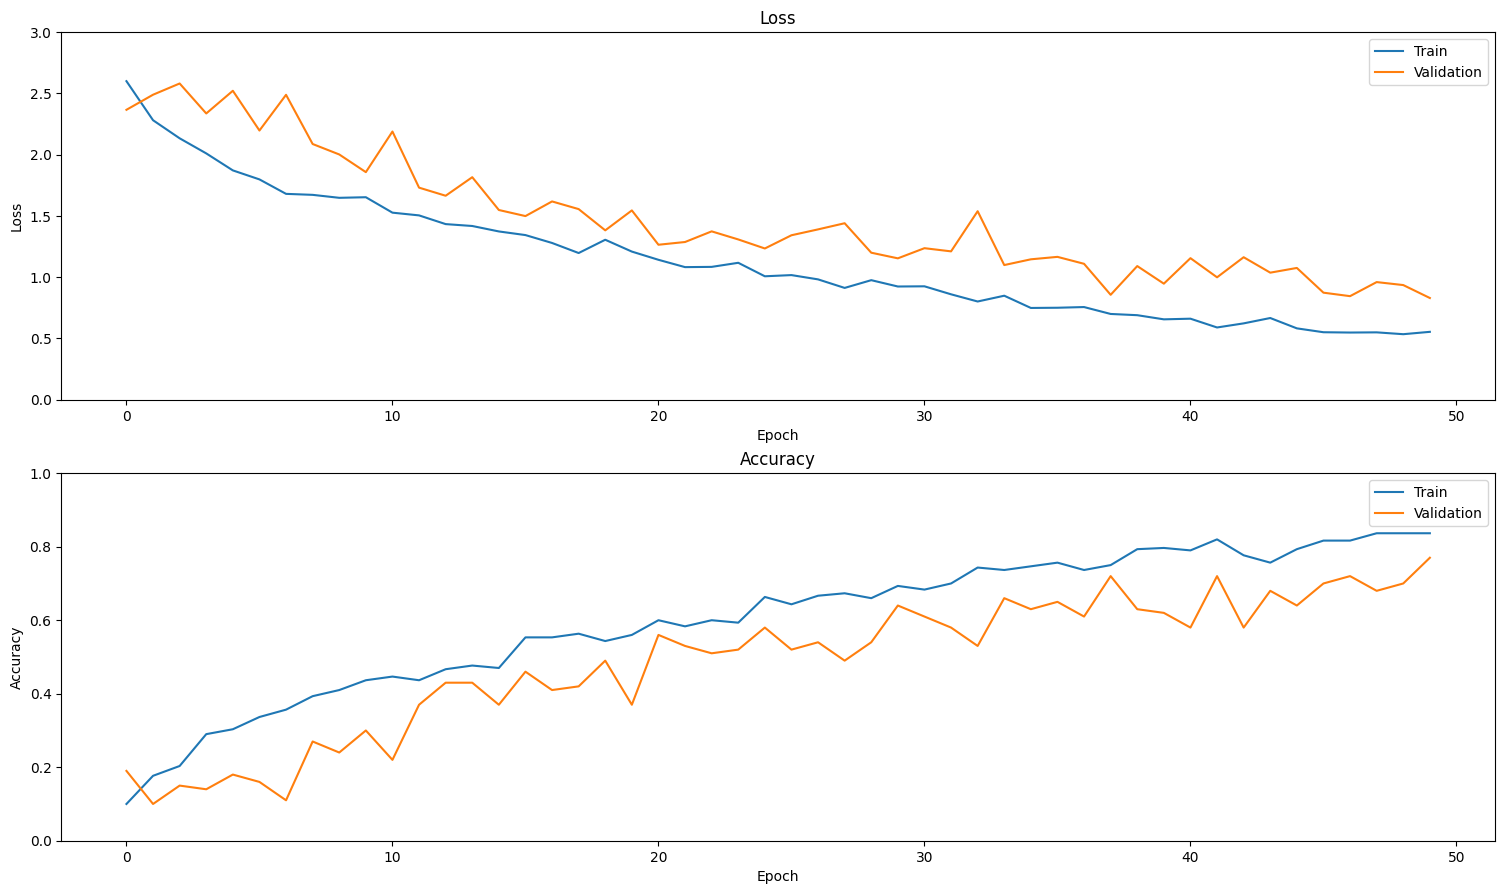

In [54]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluar el modelo

Usar `Model.evaluate` de Keras para conocer la pérdida y la precisión en el conjunto de datos de prueba.

Nota: El modelo de ejemplo de este tutorial usa un subgrupo del conjunto de datos UCF101 para mantener un tiempo de entrenamiento razonable. La precisión y la pérdida pueden mejorarse con un mayor ajuste de hiperparámetros o con más datos de entrenamiento. 

In [55]:
model.evaluate(test_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 755ms/step - accuracy: 0.6479 - loss: 0.9983


{'accuracy': 0.6700000166893005, 'loss': 0.9841411113739014}

Para visualizar mejor el rendimiento del modelo, use una [matriz de confusión](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). La matriz de confusión le permite evaluar el rendimiento del modelo de clasificación más allá de la precisión. Para construir la matriz de confusión para este problema de clasificación multiclase, obtenga los valores reales en el conjunto de pruebas y los valores predichos. 

In [56]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [57]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [58]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 733ms/step


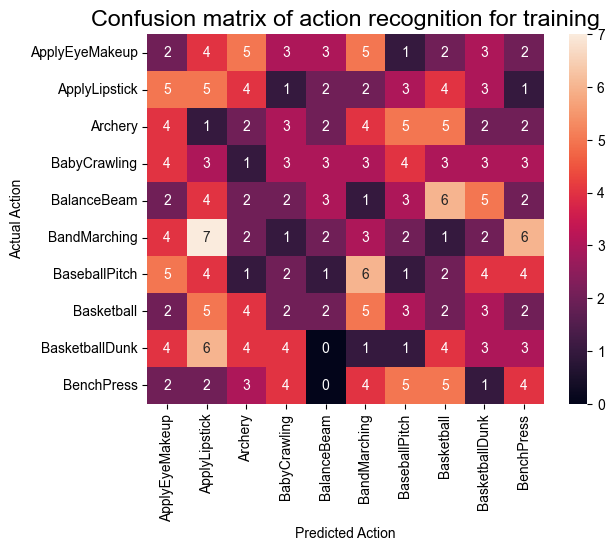

In [59]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 684ms/step


c:\Users\aleja\Desktop\Master\05 - IA Generativa\Desarrollo\10-CNN\.venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


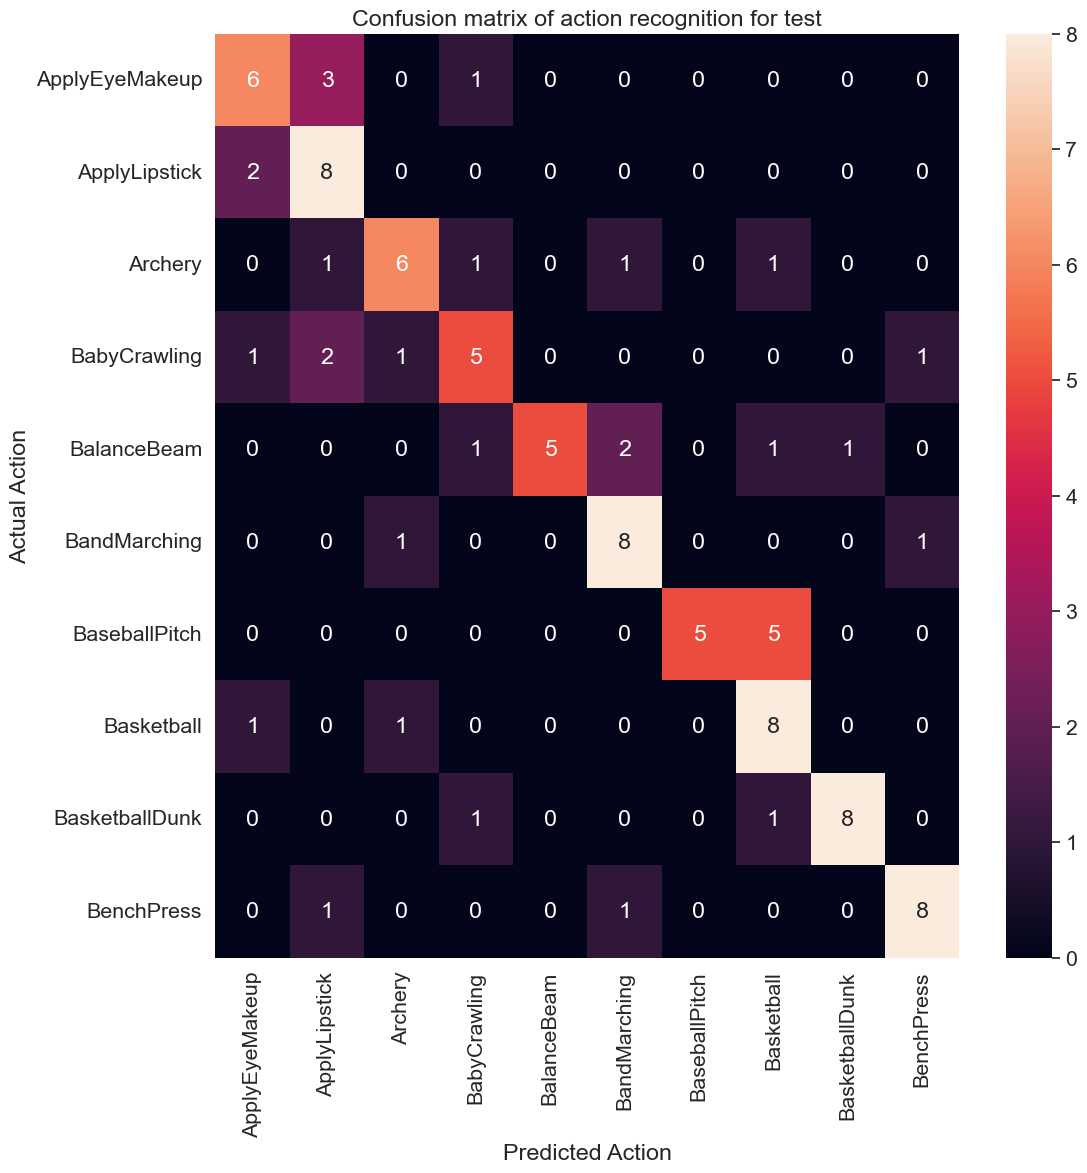

In [60]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

Los valores de precisión y memoria de cada clase también pueden calcularse utilizando una matriz de confusión.

In [61]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [62]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [63]:
precision

{'ApplyEyeMakeup': np.float64(0.6),
 'ApplyLipstick': np.float64(0.5333333333333333),
 'Archery': np.float64(0.6666666666666666),
 'BabyCrawling': np.float64(0.5555555555555556),
 'BalanceBeam': np.float64(1.0),
 'BandMarching': np.float64(0.6666666666666666),
 'BaseballPitch': np.float64(1.0),
 'Basketball': np.float64(0.5),
 'BasketballDunk': np.float64(0.8888888888888888),
 'BenchPress': np.float64(0.8)}

In [64]:
recall

{'ApplyEyeMakeup': np.float64(0.6),
 'ApplyLipstick': np.float64(0.8),
 'Archery': np.float64(0.6),
 'BabyCrawling': np.float64(0.5),
 'BalanceBeam': np.float64(0.5),
 'BandMarching': np.float64(0.8),
 'BaseballPitch': np.float64(0.5),
 'Basketball': np.float64(0.8),
 'BasketballDunk': np.float64(0.8),
 'BenchPress': np.float64(0.8)}

## Siguientes pasos

Para más información sobre cómo trabajar con datos de video en TensorFlow, consulte los siguientes tutoriales:

- [Carga de datos de video](https://www.tensorflow.org/tutorials/load_data/video)
- [MoViNet para reconocimiento de acciones de transmisión](https://www.tensorflow.org/hub/tutorials/movinet)
- [Aprendizaje por transferencia para clasificación de video con MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Segmentación de imágenes

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/segmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">Ver en TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Ejecutar en Google Colab</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/es-419/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">Ver fuente en GitHub</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/es-419/tutorials/images/segmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">Descargar el bloc de notas</a></td>
</table>

Este tutorial se enfoca en la tarea de segmentación de imágenes, usando una <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a> modificada.

## ¿Qué es la segmentación de imágenes?

En una tarea de clasificación de imágenes, la red asigna una etiqueta (o clase) a cada imagen de entrada. Pero supongamos que desea conocer la forma de ese objeto, qué pixel pertenece a qué objeto, etc. En este caso, necesita asignar una clase a cada pixel de la imagen; esta tarea se conoce como segmentación. Un modelo de segmentación devuelve información mucho más detallada sobre la imagen. La segmentación de imágenes tiene muchas aplicaciones en el diagnóstico médico por imagen, los coches autónomos y las imágenes por satélite, por nombrar sólo algunas.

Este tutorial usa el conjunto de datos [Oxford-IIIT Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). El conjunto de datos incluye imágenes de 37 razas de mascotas, con 200 imágenes por raza (~100 cada una en divisiones de entrenamiento y prueba). Cada imagen incluye las etiquetas correspondientes y máscaras a nivel de pixel. Las máscaras son etiquetas de clase para cada pixel. A cada pixel se le asigna una de tres categorías:

- Clase 1: Pixel perteneciente a la mascota.
- Clase 2: Pixel que bordea la mascota.
- Clase 3: Ninguna de las anteriores/un pixel circundante.

In [10]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to c:\users\aleja\appdata\local\temp\pip-req-build-7_w6vszi
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git 'C:\Users\aleja\AppData\Local\Temp\pip-req-build-7_w6vszi'


In [5]:
import tensorflow as tf

import tensorflow_datasets as tfds

In [6]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Descargar el conjunto de datos Oxford-IIIT Pets

El conjunto de datos está [disponible en Conjuntos de datos TensorFlow](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet). Las máscaras de segmentación se incluyen a partir de la versión 3.

In [8]:
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)

Además, los valores de color de la imagen se normalizan al rango `[0, 1]`. Por último, como se ha mencionado anteriormente, los pixeles de la máscara de segmentación se etiquetan como {1, 2, 3}. Para que resulte más cómodo, se resta 1 de la máscara de segmentación, lo que da como resultado las etiquetas: {0, 1, 2}.

In [9]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [10]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

El conjunto de datos ya contiene las divisiones de entrenamiento y prueba necesarias, así que siga usando las mismas divisiones:

In [11]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [12]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

La siguiente clase ejecuta un simple aumento volteando aleatoriamente una imagen. Vaya al tutorial [Aumento de imágenes](data_augmentation.ipynb) para obtener más información.


In [13]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Construya la canalización de entrada, aplicando el aumento tras la división en lotes de las entradas:

In [14]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualice un ejemplo de imagen y su máscara correspondiente desde el conjunto de datos:

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

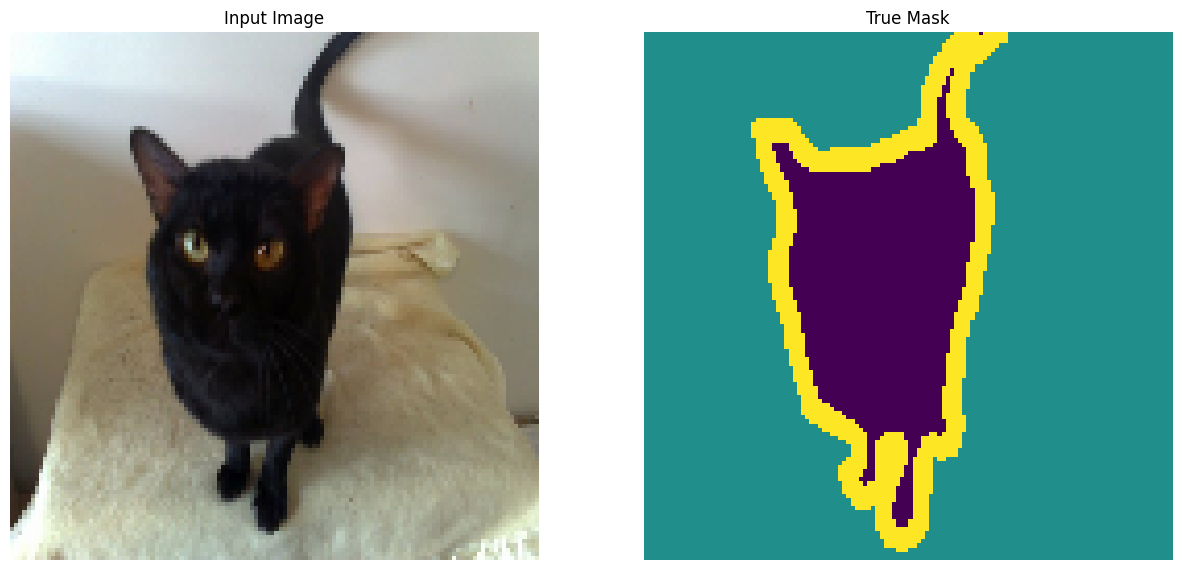

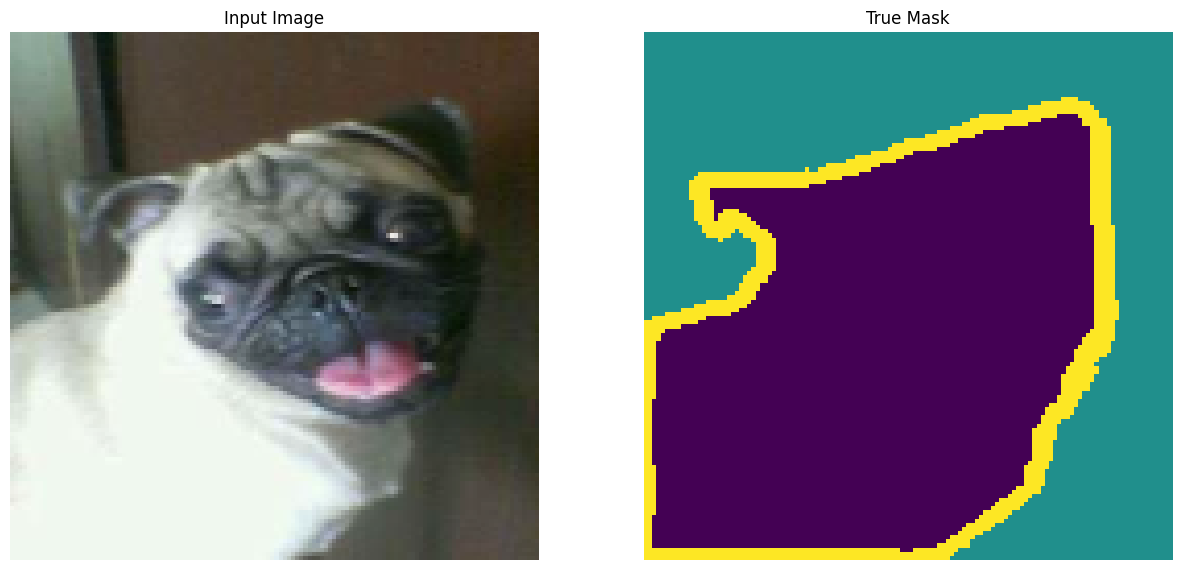

In [16]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Definir el modelo

El modelo que se usa aquí es una [U-Net](https://arxiv.org/abs/1505.04597) modificada. Una U-Net consta de un codificador (downsampler) y un decodificador (upsampler). Si quiere aprender características robustas y reducir el número de parámetros entrenables, use un modelo preentrenado ([MobileNetV2](https://arxiv.org/abs/1801.04381)) como codificador. Para el decodificador, usará el bloque upsample, que ya está implementado en el ejemplo [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) del repositorio de ejemplos de TensorFlow. (Eche un vistazo al tutorial [pix2pix: Traducción imagen a imagen con un GAN condicional](../generative/pix2pix.ipynb) en un bloc de notas).


Como se ha mencionado, el codificador es un modelo MobileNetV2 preentrenado. Usted usará el modelo de `tf.keras.applications`. El codificador consiste en salidas específicas de las capas intermedias del modelo. Tenga en cuenta que el codificador no se entrenará durante el proceso de entrenamiento.

In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


El decodificador/upsampler es simplemente una serie de bloques de upsample implementados en ejemplos de TensorFlow:

In [18]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [19]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Tenga en cuenta que el número de filtros de la última capa se establece en función del número de `output_channels`. Esto será un canal de salida por clase.

## Entrenar el modelo

Ahora sólo queda compilar y entrenar el modelo.

Dado que se trata de un problema de clasificación multiclase, use la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy` con el argumento `from_logits` como `True`, ya que las etiquetas son enteros escalares en lugar de vectores de puntuaciones para cada pixel de cada clase.

Al ejecutar la inferencia, la etiqueta asignada al pixel es el canal con el valor más alto. Esto es lo que hace la función `create_mask`.

In [20]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Trace la arquitectura del modelo resultante:

In [21]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Pruebe el modelo para comprobar lo que predice antes del entrenamiento:

In [22]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


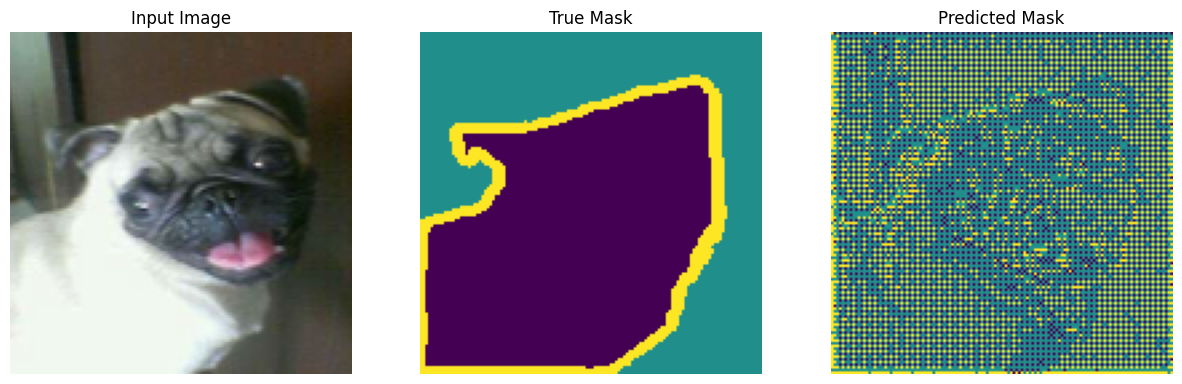

In [24]:
show_predictions()

La retrollamada definida a continuación se usa para observar cómo mejora el modelo mientras se entrena:

In [25]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


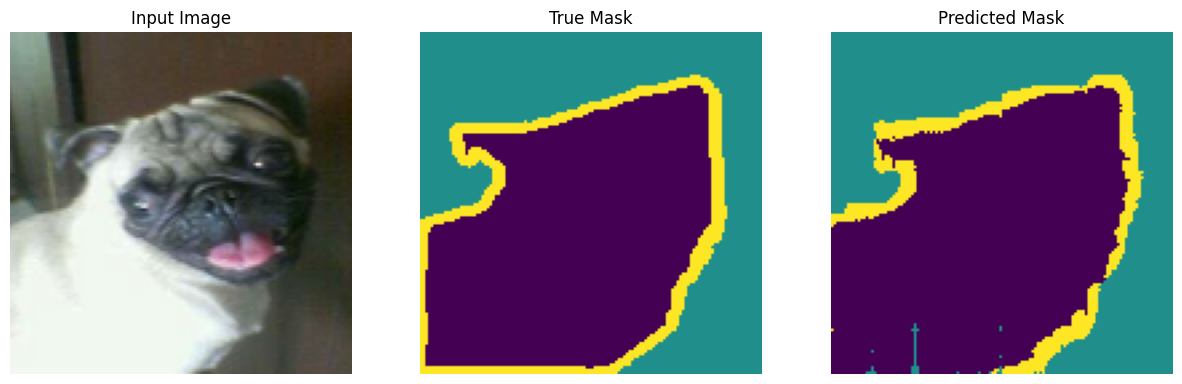


Sample Prediction after epoch 20

57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 820ms/step - accuracy: 0.9291 - loss: 0.1735 - val_accuracy: 0.9047 - val_loss: 0.2677


In [26]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

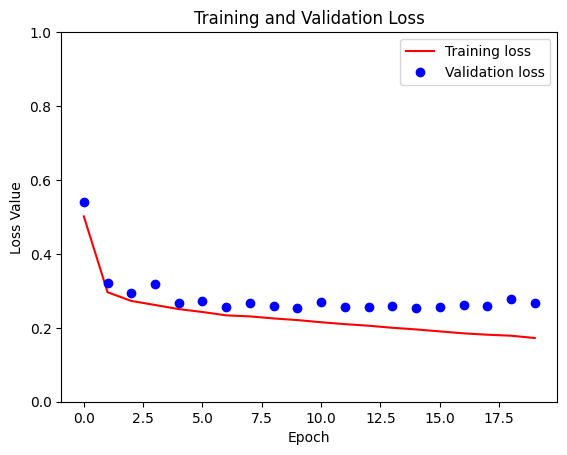

In [27]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Hacer predicciones

Ahora, haga algunas predicciones. Para ahorrar tiempo, mantuvimos un número reducido de épocas, pero puede fijarlo más alto para obtener resultados más precisos.

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


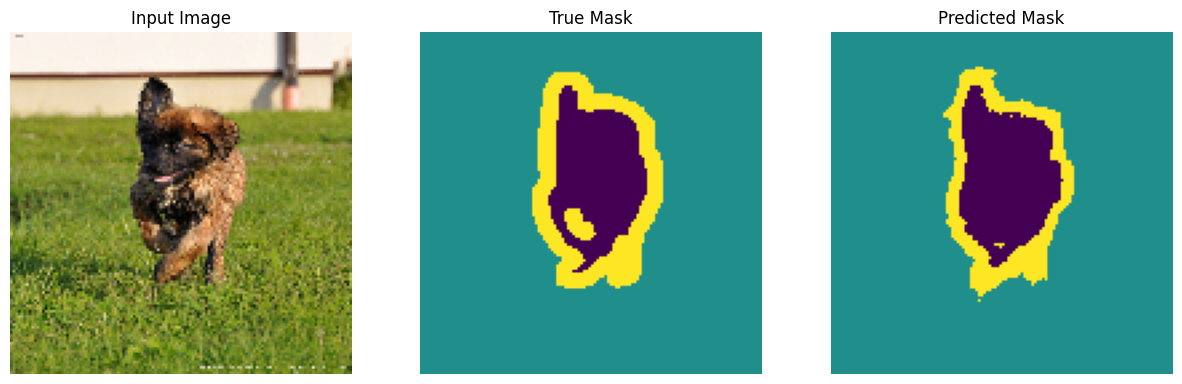

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


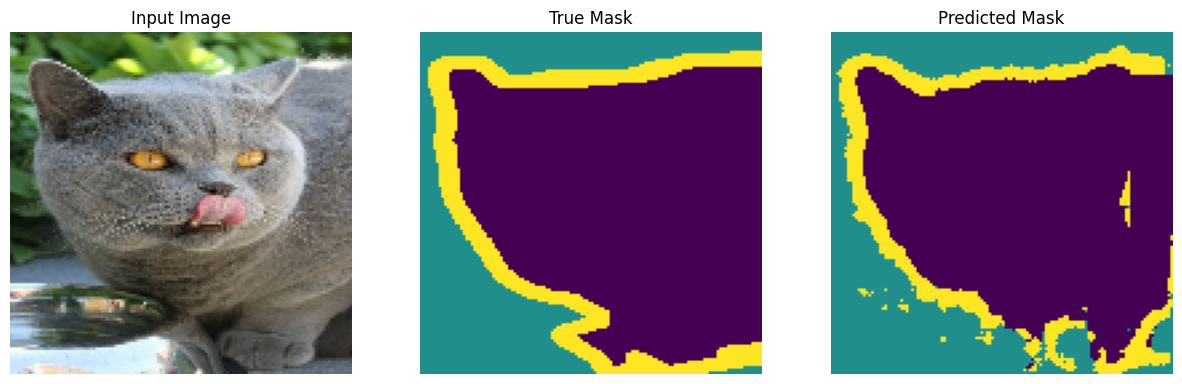

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


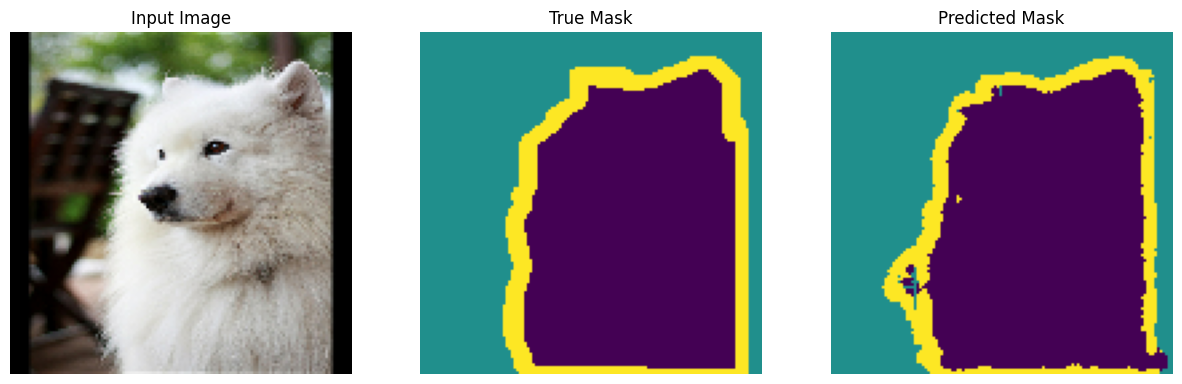

In [28]:
show_predictions(test_batches, 3)

## Opcional: Clases desequilibradas y ponderaciones por clase

Los conjuntos de datos de segmentación semántica pueden estar muy desequilibrados, lo que significa que los pixeles de una clase concreta pueden estar más presentes dentro de las imágenes que los de otras clases. Dado que los problemas de segmentación pueden tratarse como problemas de clasificación por pixel, puede abordar el problema del desequilibrio asignando ponderaciones a la función de pérdida para compensarlo. Es una forma sencilla y elegante de lidiar con este problema. Consulte el tutorial [Clasificación en datos desequilibrados](../structured_data/imbalanced_data.ipynb) para saber más.

Para [evitar ambigüedades](https://github.com/keras-team/keras/issues/3653#issuecomment-243939748), `Model.fit` no admite el argumento `class_weight` para objetivos con más de 3 dimensiones.

In [29]:
try:
  model_history = model.fit(train_batches, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            class_weight = {0:2.0, 1:2.0, 2:1.0})
  assert False
except Exception as e:
  print(f"Expected {type(e).__name__}: {e}")

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 47s 793ms/step - accuracy: 0.9251 - loss: 0.2463
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 866ms/step - accuracy: 0.9201 - loss: 0.2655
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 49s 862ms/step - accuracy: 0.9246 - loss: 0.2475
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 981ms/step - accuracy: 0.9267 - loss: 0.2383
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9292 - loss: 0.2285
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 51s 898ms/step - accuracy: 0.9326 - loss: 0.2150
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 979ms/step - accuracy: 0.9331 - loss: 0.2150
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 926ms/step - accuracy: 0.9353 - loss: 0.2044
Epoch 9/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 922ms/step - accuracy: 0.9351 - loss: 0.2084
Epoch 10/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 927ms/step - accuracy: 0.9382 - loss: 0.1956
Epoch 11/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 934ms/step - accuracy: 0.9395 - loss: 0.1902
Epoch 12/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 9

Por tanto, en este caso deberá implementar usted mismo la ponderación. Lo hará usando ponderaciones de muestreo: Además de los pares `(data, label)`, `Model.fit` también acepta los tripletes `(data, label, sample_weight)`.

`Model.fit` de Keras propaga el `sample_weight` a las pérdidas y métricas, que también aceptan un argumento `sample_weight`. La ponderación de la muestra se multiplica por el valor de la muestra antes del paso de reducción. Por ejemplo:

In [30]:
label = [0,0]
prediction = [[-3., 0], [-3, 0]] 
sample_weight = [1, 10] 

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                               reduction=tf.keras.losses.Reduction.NONE)
loss(label, prediction, sample_weight).numpy()

ValueError: Structures don't have the same nested structure.

Así, para hacer ponderaciones de muestra para este tutorial, se necesita una función que tome un par `(data, label)` y devuelva un triplete `(data, label, sample_weight)` donde el `sample_weight` es una imagen de 1 canal que contiene la ponderación de clase para cada pixel.

La implementación más sencilla posible es usar la etiqueta como índice en una lista `class_weight`:

In [31]:
def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  class_weights = tf.constant([2.0, 2.0, 1.0])
  class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

Los elementos del conjunto de datos resultante contienen 3 imágenes cada uno:

In [32]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

Ahora ya puede entrenar un modelo en este conjunto de datos ponderado:

In [33]:
weighted_model = unet_model(OUTPUT_CLASSES)
weighted_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [34]:
weighted_model.fit(
    train_batches.map(add_sample_weights),
    epochs=1,
    steps_per_epoch=10)

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.4291 - loss: 0.4558


## Siguientes pasos

Ahora que ya sabe qué es la segmentación de imágenes y cómo funciona, puede probar este tutorial con diferentes salidas de capas intermedias, o incluso con diferentes modelos preentrenados. También puede retarse a sí mismo probando el reto de enmascaramiento de imágenes de [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge/overview) alojado en Kaggle.

También puede consultar la [API de detección de objetos de Tensorflow](https://github.com/tensorflow/models/blob/master/research/object_detection/README.md) para ver otro modelo que puede volver a entrenar con sus propios datos. Los modelos preentrenados están disponibles en [TensorFlow Hub](https://www.tensorflow.org/hub/tutorials/tf2_object_detection#optional).